In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import largestinteriorrectangle as lir

In [2]:
def generate_convex_polygon(image_size=64, num_points=9):
    # 生成随机点
    points = np.random.randint(0, image_size, (num_points, 2))
    
    # 计算凸包
    hull = ConvexHull(points)
    
    # 返回凸包的顶点
    return points[hull.vertices]

In [3]:
def generate_random_polygon_image(image_size=64, num_points=6):
    # 生成随机的多边形顶点
    points = generate_convex_polygon(image_size, num_points)
    # 创建空白图像
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    # 画出多边形
    cv2.fillPoly(image, [points], 255)
    # 返回多边形图像和顶点（在真实问题中，你可能希望返回内接矩形的标签）
    return image, points

In [75]:
# # 展示生成的多边形
# def display_polygon_image():
#     # 生成多边形
#     num_points = np.random.randint(5, 21)
#     print(num_points)
#     image, points = generate_random_polygon_image(image_size=64, num_points=9)
#     rectangle =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
#     rect = np.array([(rectangle[0],rectangle[1]), 
#                      (rectangle[0],rectangle[1]+rectangle[3]-1), 
#                      (rectangle[0]+rectangle[2]-1,rectangle[1]+rectangle[3]-1),
#                      (rectangle[0]+rectangle[2]-1,rectangle[1])])
#     rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    
#     # 显示图像
#     plt.figure(figsize=(5, 5))
#     print(image.shape)
#     plt.imshow(image, cmap='gray')  # 灰度图像
#     plt.plot(rect[:, 0], rect[:, 1], 'r--')
#     # plt.scatter(points[:, 0], points[:, 1], color='red')  # 标记多边形的顶点
#     plt.title('Random Polygon')
#     plt.show()

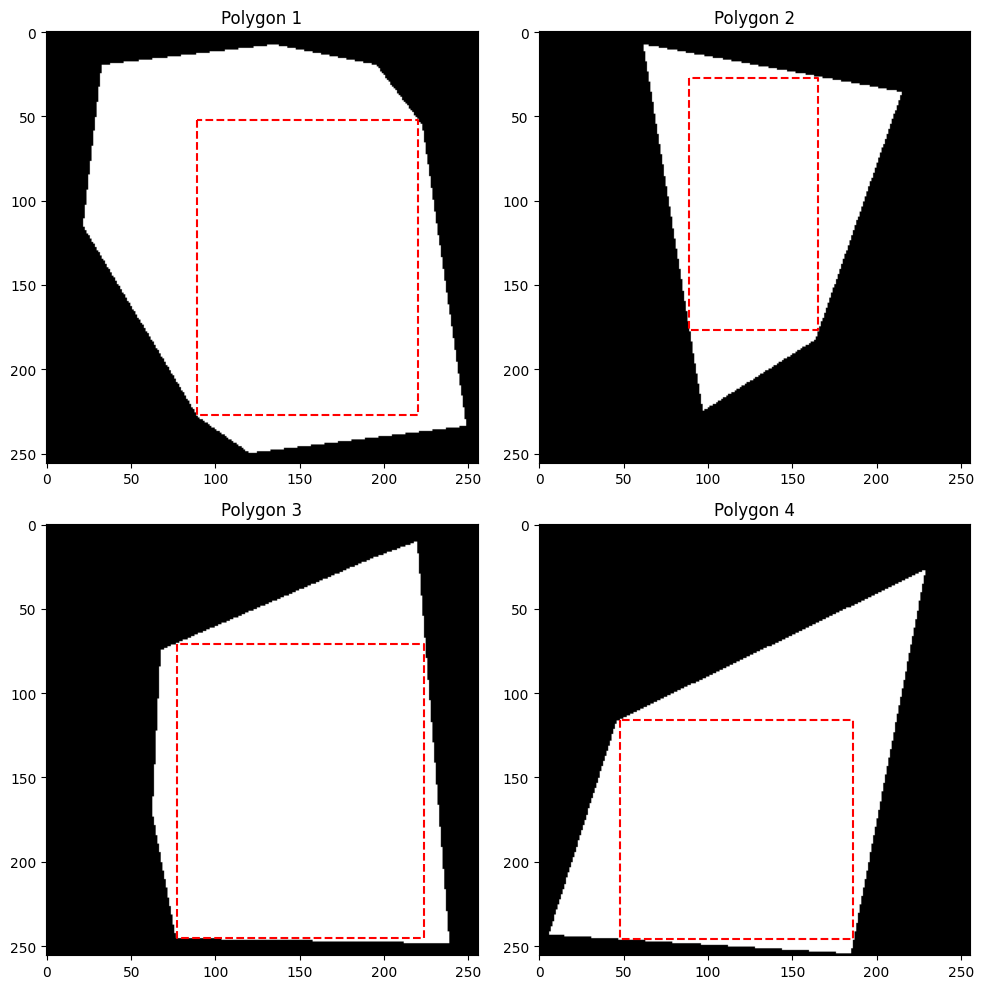

In [6]:
# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# 将子图展平为一维数组
axs = axs.flatten()
for i in range(4):
    point_range=[5,21]
    num_points = np.random.randint(point_range[0], point_range[1])
    image, _ = generate_random_polygon_image(image_size=256, num_points=num_points)
    # point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')    
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同
        
# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

In [8]:
# 生成训练数据 (多边形和最大内接矩形参数)
def generate_training_data(num_samples=1000, image_size=64, point_range=[5,21]) :
    data = []
    for _ in range(num_samples):
        num_points = np.random.randint(point_range[0], point_range[1])
        image, _ = generate_random_polygon_image(image_size=image_size, num_points=9)
        point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
        data.append((image.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    return data

In [9]:
%%time
import os
import pickle

# 保存为二进制文件
file_path = "data_max.pkl"
train_data = None
if os.path.exists(file_path):
    print("从文件导入训练数据")
    with open(file_path, 'rb') as file:
        train_data = pickle.load(file)  # 这里应该传递文件对象，而不是文件路径
else:
    print("生成训练数据")
    train_data = generate_training_data(num_samples=10000, image_size=256, point_range=[5,39])
    with open(file_path, 'wb') as file:
        pickle.dump(train_data, file)

生成训练数据
CPU times: total: 1h 39min 18s
Wall time: 14min 26s


In [10]:
train_data[0:2], len(train_data)

([(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
   array([ 37, 135, 100,  98], dtype=uint32)),
  (array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
   array([ 76, 137, 108,  69], dtype=uint32))],
 10000)

In [11]:
# 展示生成的多边形
def display_polygon_image_x(image, rectangle):
    rect = np.array([(rectangle[0],rectangle[1]), 
                     (rectangle[0],rectangle[1]+rectangle[3]-1), 
                     (rectangle[0]+rectangle[2]-1,rectangle[1]+rectangle[3]-1),
                     (rectangle[0]+rectangle[2]-1,rectangle[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    
    # 显示图像
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')  # 灰度图像
    plt.plot(rect[:, 0], rect[:, 1], 'r--')
    # plt.scatter(points[:, 0], points[:, 1], color='red')  # 标记多边形的顶点
    plt.title('Random Polygon')
    plt.show()

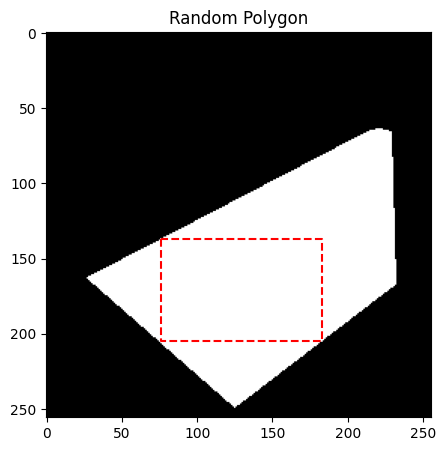

In [13]:
display_polygon_image_x(train_data[1][0].reshape(256,256),train_data[1][1])

In [14]:
dataset = TensorDataset(torch.tensor([x[0] for x in train_data], dtype=torch.float32), torch.tensor([x[1] for x in train_data], dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

C:\Users\loki_\AppData\Local\Temp\ipykernel_13832\596144479.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  dataset = TensorDataset(torch.tensor([x[0] for x in train_data], dtype=torch.float32), torch.tensor([x[1] for x in train_data], dtype=torch.float32))


In [15]:
# 简单的全连接神经网络
class RectNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(RectNet, self).__init__()
        # self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, output_size)
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),       
            nn.LeakyReLU(0.02),
            # nn.Dropout(0.5),      # Dropout 层
        
            # 10 filters to 10 filters
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),          
            nn.LeakyReLU(0.02),    
            # nn.Dropout(0.3),      # Dropout 层
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        return self.model(x)

In [16]:
len(train_data[0][0])

65536

In [17]:
model = RectNet(input_size=len(train_data[0][0]), output_size=4)

In [18]:
# 优化器 - Adam，学习率为0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 学习率调度器 - 每10个epoch降低学习率
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

In [19]:
# 训练模型
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()  # 训练模式
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()  # 清空梯度
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            
            # 反向传播
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()  # 更新权重
            
            running_loss += loss.item()
        
        # 学习率调度
        scheduler.step()
        
        # 打印每个epoch的平均损失
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [24]:
train(model, dataloader, criterion, optimizer, scheduler, num_epochs=20)

Epoch [1/20], Loss: 116.8312
Epoch [2/20], Loss: 119.6111
Epoch [3/20], Loss: 117.2666
Epoch [4/20], Loss: 116.4150
Epoch [5/20], Loss: 116.8062
Epoch [6/20], Loss: 119.4979
Epoch [7/20], Loss: 115.8355
Epoch [8/20], Loss: 117.9061
Epoch [9/20], Loss: 116.1576
Epoch [10/20], Loss: 115.9549
Epoch [11/20], Loss: 116.9707
Epoch [12/20], Loss: 116.3587
Epoch [13/20], Loss: 117.2741
Epoch [14/20], Loss: 118.8478
Epoch [15/20], Loss: 116.1146
Epoch [16/20], Loss: 119.2973
Epoch [17/20], Loss: 116.4588
Epoch [18/20], Loss: 113.2670
Epoch [19/20], Loss: 113.6097
Epoch [20/20], Loss: 116.9172


In [23]:
# num_points = np.random.randint(point_range[0], point_range[1])
# testimages, _ = generate_random_polygon_image(image_size=64, num_points=9)

*************************
point = [ 10.974441  53.79614  191.20197  149.15546 ]
real_point = [ 18  55 187 140]
loss = 38.0716667175293
hand loss = [ 7.02555943  1.20386124 -4.20196533 -9.15545654]
*************************
point = [ 20.069769  53.39631  221.58775  169.99648 ]
real_point = [ 51  47 193 184]
loss = 502.7375793457031
hand loss = [ 30.93023109  -6.3963089  -28.5877533   14.00352478]
*************************
point = [ 24.876347  25.37437  197.32901  191.55818 ]
real_point = [ 26  37 216 164]
loss = 311.1192626953125
hand loss = [  1.12365341  11.62562943  18.67098999 -27.55818176]
*************************
point = [ 58.19983   25.603975 171.34691  201.89062 ]
real_point = [ 67  27 176 215]
loss = 68.22471618652344
hand loss = [ 8.8001709   1.3960247   4.65309143 13.109375  ]


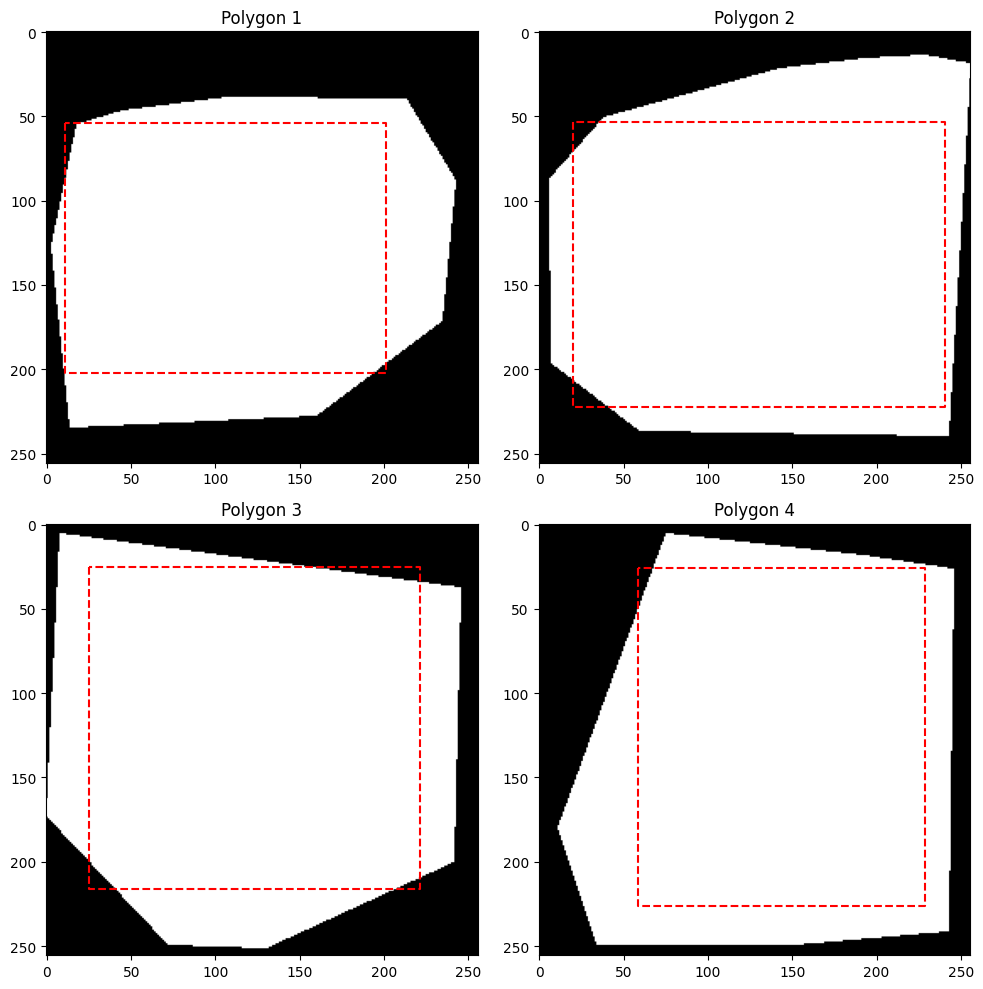

In [25]:
# 生成4个凸多边形
model.eval()

# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# 将子图展平为一维数组
axs = axs.flatten()
for i in range(4):
    # num_points = np.random.randint(point_range[0], point_range[1])
    num_points = np.random.randint(21, 36)
    image, _ = generate_random_polygon_image(image_size=256, num_points=num_points)
    # image = train_data[i+4][0].reshape(64,64)
    real_point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    # data.append((image.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    with torch.no_grad():
        test_input = torch.tensor(image.flatten(), dtype=torch.float32).unsqueeze(0)
        # point = model(test_input).squeeze().numpy()
        output = model(test_input)
        # print(f"output = {output}  | output.squeeze = {output.squeeze()} ") 
        # print(f"type(output.squeeze())  = {output.squeeze().shape} ")
        # print(f"type(real_point)  = {real_point.shape} ")
        # break
        loss = criterion(output.squeeze(), torch.tensor(real_point, dtype=torch.float32))      
        point = output.squeeze().numpy()
        print("*"*25)
        print(f"point = {point}")
        print(f"real_point = {real_point}")
        print(f"loss = {loss}")
        # print(f"hand loss = {sum((real_point - point)**2)/4}")
        print(f"hand loss = {real_point - point}")
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')    
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同
        
# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()